In [1]:
outputfolder  = "plots/"
save_plots    = False
inputfilename = "/Users/Gonzalo/github/NEXTdata/Na22/run3614.dst"

In [2]:
from __future__ import print_function, division

import os
import sys
import time
import glob

import tables            as tb
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions  as coref
import invisible_cities.core.fit_functions   as fitf
import invisible_cities.reco.peak_functions  as pf
import invisible_cities.reco.pmaps_functions as pf
import invisible_cities.reco.tbl_functions   as tbf
import invisible_cities.reco.dst_functions   as dstf

from invisible_cities.reco.params import Correction

pi = np.pi

print("Running on ", time.asctime())

Running on  Fri Apr 14 17:15:15 2017


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8

In [4]:
def load_z_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "Zcorrections")
    return Correction(dst.z.values, dst.factor.values, dst.uncertainty.values)


def load_xy_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "XYcorrections")
    x    = np.unique (dst.x          .values)
    y    = np.unique (dst.y          .values)
    f    = np.reshape(dst.factor     .values, (len(x), len(y)))
    u    = np.reshape(dst.uncertainty.values, (len(x), len(y)))
    return Correction((x,y), f, u)

def load_t_corrections(filename):
    dst  = dstf.load_dst(filename, "Corrections", "Tcorrections")
    return Correction(dst.t.values, dst.factor.values, dst.uncertainty.values)



In [5]:
corrfilename = "/Users/Gonzalo/github/NEXTdata/Alphas/run3628.corr"
zcorr  = load_z_corrections (corrfilename)
xycorr = load_xy_corrections(corrfilename)
tcorr  = load_t_corrections (corrfilename)

In [6]:
dst = dstf.load_dst(inputfilename, "DST", "Events")
dst.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.491674e+09,0,1,275.0,49.620018,287.162550,537150.0,40.100437,13367.398438,...,657112.5,54,119.9625,119.9625,97.811136,40.847802,105.997930,0.395602,25.243436,11.175782
1,2,1.491674e+09,0,1,200.0,24.205078,129.749825,557000.0,38.343750,10287.787109,...,653687.5,25,96.6875,96.6875,136.927309,5.200002,137.026012,0.037958,9.209800,10.444016
2,4,1.491674e+09,0,1,225.0,30.098822,160.997304,470600.0,23.514125,8284.446289,...,664512.5,19,193.9125,193.9125,-55.612291,-10.052078,56.513460,-2.962771,10.149977,8.824298
3,5,1.491674e+09,0,2,225.0,54.494896,286.139376,615225.0,45.152500,10520.092773,...,672387.5,54,57.1625,57.1625,-21.676225,165.445635,166.859572,1.701072,15.885687,18.841620
4,5,1.491674e+09,1,2,225.0,54.494896,286.139376,615225.0,29.291875,6783.470215,...,918112.5,26,302.8875,302.8875,-168.863477,45.446878,174.872218,2.878688,9.241491,15.903105


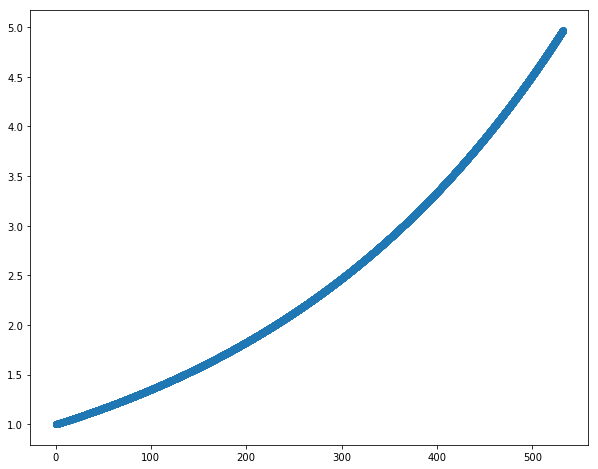

In [7]:
plt.scatter(zcorr.xs, zcorr.fs)

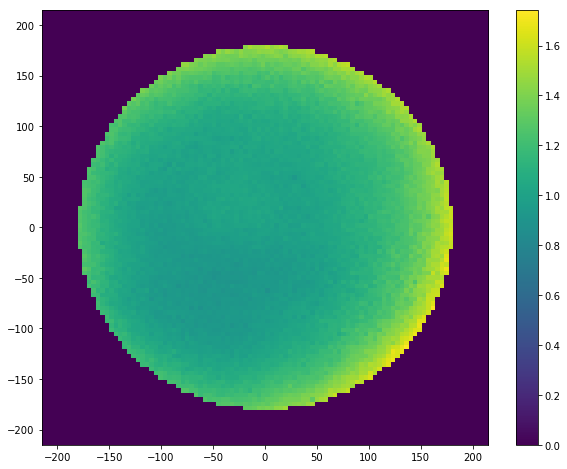

In [8]:
(x, y), e = xycorr.xs.T, xycorr.fs.flatten()
x = np.repeat(x, x.size)
y = np.tile  (y, y.size)

sel = (x**2 + y**2) < 180**2
x = x[sel]
y = y[sel]
e = e[sel]

plt.hist2d(x, y, (100,100), range=((-215,215), (-215,215)), weights=e)
plt.colorbar()

F0: [  2.93007191e+06   5.46985596e+03   1.23130305e+03]
F1: [  2.35347341e+06   8.44076606e+03   9.56233911e+02]
F2: [  2.06867489e+06   8.71569407e+03   8.68162395e+02]


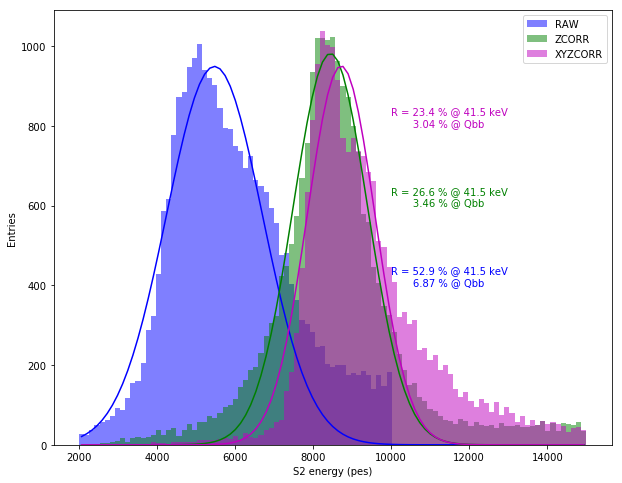

In [9]:
data = dst[fitf.in_range(dst.S2e, 0, 1e4)]

bins = np.linspace(2e3, 15e3, 100)
E = np.array(data.S2e.values)
plt.figure()
y0, x0, _ = plt.hist(E, bins, label="RAW", alpha=0.5, color="b"); x0 = x0[:-1] + np.diff(x0) * 0.5

E *= zcorr(data.Z.values)[0]
y1, x1, _ = plt.hist(E, bins, label="ZCORR", alpha=0.5, color="g"); x1 = x1[:-1] + np.diff(x1) * 0.5

E *= xycorr(data.X.values, data.Y.values)[0]
y2, x2, _ = plt.hist(E, bins, label="XYZCORR", alpha=0.5, color="m"); x2 = x2[:-1] + np.diff(x2) * 0.5


m0, m1, m2 = x0[np.argmax(y0)], x1[np.argmax(y1)], x2[np.argmax(y2)]
f0 = fitf.fit(fitf.gauss, x0, y0, (1e6, m0, 300), fit_range=(m0 - 2000, m0 + 2000))
f1 = fitf.fit(fitf.gauss, x1, y1, (1e6, m1, 300), fit_range=(m1 - 2000, m1 + 2000))
f2 = fitf.fit(fitf.gauss, x2, y2, (1e6, m2, 300), fit_range=(m2 - 2000, m2 + 2000))

plt.plot(x0, f0.fn(x0), "b-")
plt.plot(x1, f1.fn(x1), "g-")
plt.plot(x2, f2.fn(x2), "m-")

r0, r1, r2 = 235 * f0.values[2]/f0.values[1], 235 * f1.values[2]/f1.values[1], 235 * f2.values[2]/f2.values[1]
plt.text(10e3, 400, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r0, r0 * (41.5/2458)**0.5), color="b")
plt.text(10e3, 600, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r1, r1 * (41.5/2458)**0.5), color="g")
plt.text(10e3, 800, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r2, r2 * (41.5/2458)**0.5), color="m")

plt.legend()

plt.xlabel("S2 energy (pes)")
plt.ylabel("Entries")

print("F0:", f0.values)
print("F1:", f1.values)
print("F2:", f2.values)

F0: [  2.16327311e+08   8.41984528e+04   1.24699954e+04]
F1: [  1.73770455e+08   1.38684402e+05   1.56404918e+04]
F2: [  1.45695255e+08   1.38958949e+05   1.33120313e+04]


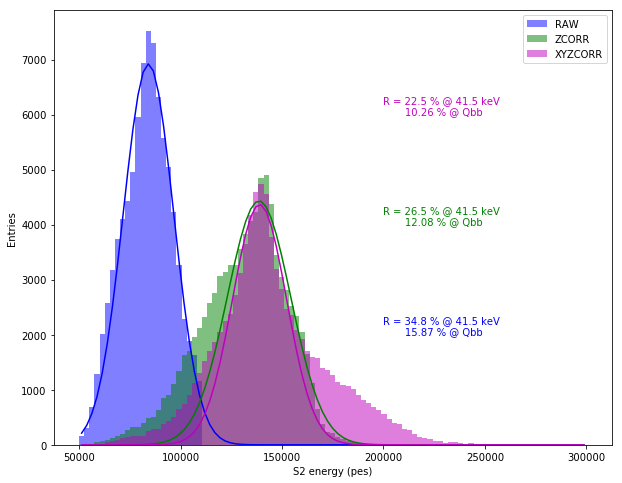

In [10]:
data = dst [fitf.in_range(dst.S1e,   100,   150)]
data = data[fitf.in_range(data.S2e, 50e3, 110e3)]

bins = np.linspace(50e3, 30e4, 100)
E = np.array(data.S2e.values)
plt.figure()
y0, x0, _ = plt.hist(E, bins, label="RAW", alpha=0.5, color="b"); x0 = x0[:-1] + np.diff(x0) * 0.5

E *= zcorr(data.Z.values)[0]
y1, x1, _ = plt.hist(E, bins, label="ZCORR", alpha=0.5, color="g"); x1 = x1[:-1] + np.diff(x1) * 0.5

E *= xycorr(data.X.values, data.Y.values)[0]
y2, x2, _ = plt.hist(E, bins, label="XYZCORR", alpha=0.5, color="m"); x2 = x2[:-1] + np.diff(x2) * 0.5


m0, m1, m2 = x0[np.argmax(y0)], x1[np.argmax(y1)], x2[np.argmax(y2)]
f0 = fitf.fit(fitf.gauss, x0, y0, (1e8, m0, 3000), fit_range=(m0 - 20000, m0 + 20000))
f1 = fitf.fit(fitf.gauss, x1, y1, (1e8, m1, 3000), fit_range=(m1 - 20000, m1 + 20000))
f2 = fitf.fit(fitf.gauss, x2, y2, (1e8, m2, 3000), fit_range=(m2 - 20000, m2 + 20000))

plt.plot(x0, f0.fn(x0), "b-")
plt.plot(x1, f1.fn(x1), "g-")
plt.plot(x2, f2.fn(x2), "m-")

r0, r1, r2 = 235 * f0.values[2]/f0.values[1], 235 * f1.values[2]/f1.values[1], 235 * f2.values[2]/f2.values[1]
plt.text(200e3, 2000, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r0, r0 * (511/2458)**0.5), color="b")
plt.text(200e3, 4000, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r1, r1 * (511/2458)**0.5), color="g")
plt.text(200e3, 6000, "R = {:.1f} % @ 41.5 keV\n       {:.2f} % @ Qbb".format(r2, r2 * (511/2458)**0.5), color="m")

plt.legend()

plt.xlabel("S2 energy (pes)")
plt.ylabel("Entries")

print("F0:", f0.values)
print("F1:", f1.values)
print("F2:", f2.values)